In [1]:
# investigate the difference between TC indicators for different SSPs
#
#   Quote: "for 90% (95%) of the national shares of people exposed for a specific
#   RCP-year-country combination, the difference between the SSPs is less than 5% (10%)"
#

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

import tc_cost.util.constants as u_const
import tc_cost.util.data as u_data

In [2]:
def read_aff_people_proj():
    l_rcp = ["rcp26_baseline"] + u_const.L_RCP_LOWER
    ds_aff = (
        u_data.load_ssp_data()
        .sel(SSP=u_const.L_SSP)
        .sel(ISO=u_const.L_COUNTRIES)
        .reindex(
            year=np.arange(u_const.SSP_PERIOD[0], u_const.SSP_PERIOD[1] + 1)
        ).squeeze()
    )
    ds_aff['aff_share'] = xr.combine_nested([
        [
            u_data.load_affected_people(
                rcp[:5], ssp, "baseline" if "baseline" in rcp else "full", shares=True,
            )
            for rcp in l_rcp
        ] for ssp in u_const.L_SSP
    ], concat_dim=["SSP", "rcp"])
    ds_aff['rcp'] = ("rcp", l_rcp)
    ds_aff['gmt'] = xr.open_dataset(u_const.GMT_NC)['gmt']
    return ds_aff

In [3]:
ds_aff = read_aff_people_proj()
for q in [0.167, 0.50, 0.833]:
    ds_aff[f'aff_{100 * q:.0f}'] = ds_aff['aff_share'].quantile(
        q=q, dim=["realisation", "gcm"])
ds_aff = ds_aff[[f"aff_{q}" for q in [17, 50, 83]]].squeeze()

Loading cached data from /home/tovogt/code/tc_cost/data/cache/SspDb_GDP_POP_OECD_Env-Growth.nc ...


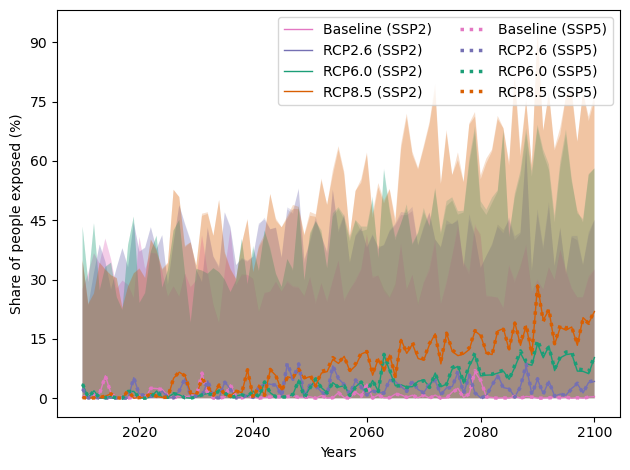

In [4]:
fig = plt.figure()
ax = fig.gca()

iso = "BGD"
l_rcp = ["rcp26_baseline"] + u_const.L_RCP_LOWER
colors = [u_const.L_RCP_COLORS[rcp] for rcp in ["baseline"] + u_const.L_RCP_LOWER]

for ssp in u_const.L_SSP:
    for color, rcp in zip(colors, l_rcp):
        ds = ds_aff.sel(rcp=rcp, SSP=ssp, ISO=iso)
        ax.plot(
            ds.year,
            100 * ds.aff_50,
            c=color,
            label=(
                "Baseline" if rcp.endswith("baseline") else f"RCP{float(rcp[3:]) / 10:.1f}"
            ) + f" ({ssp})",
            linestyle=":" if ssp == "SSP5" else "-",
            linewidth=2.5 if ssp == "SSP5" else 1.0,
        )
        ax.fill_between(
            ds.year,
            100 * ds.aff_17,
            100 * ds.aff_83,
            facecolor=color,
            alpha=0.2,
            edgecolor="none",
        )

ax.set_xlabel("Years")
ax.set_xticks(np.arange(2020, 2101, 20))

ax.set_ylabel("Share of people exposed (%)")
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.legend(ncol=2)

fig.tight_layout()

In [5]:
aff50 = ds_aff["aff_50"]
aff50_2 = aff50.sel(SSP="SSP2")
aff50_5 = aff50.sel(SSP="SSP5")
(
    np.abs(
        (aff50_2 - aff50_5) / np.fmax(1e-10, aff50_2)
    )
    .quantile(dim=["ISO", "rcp", "year"], q=[0.5, 0.833, 0.95, 0.975])
)

<xarray.DataArray 'aff_50' (quantile: 4)>
array([0.00355891, 0.02304523, 0.05763801, 0.09974773])
Coordinates:
  * quantile  (quantile) float64 0.5 0.833 0.95 0.975